# Notebook for Sentiment Analysis of Tweets using Neural Networks


## Useful Imports


In [1]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from nltk.stem import PorterStemmer
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load the dataset

In [2]:
# EDIT THE PATH OF THE CSV HERE
TWEETS_PATH = os.path.join(".", "drive", "My Drive", "Colab Notebooks", "AI2",
                           "Project1", "dataset", "SentimentTweets.csv")

def load_twitter_data(tweets_path=TWEETS_PATH):
  return pd.read_csv(tweets_path)

df = load_twitter_data(tweets_path=TWEETS_PATH)

## Take a look at the Dataset

In [3]:
df.head()

,Unnamed: 0,target,id,date,flag,user,text
0,680949,0,2249621587,Fri Jun 19 22:41:08 PDT 2009,NO_QUERY,sukumarpant,#brokenpromises...
1,406741,0,2059003515,Sat Jun 06 16:03:21 PDT 2009,NO_QUERY,MTMSparrow,David Carradine so sad. Thai's law not sure i...
2,1337108,4,2017466467,Wed Jun 03 08:26:14 PDT 2009,NO_QUERY,itsmemcee,A @ 415 B @ 425. Tell your bro i say congrats!
3,1560887,4,2186457254,Mon Jun 15 18:52:04 PDT 2009,NO_QUERY,jdfreivald,@littlefluffycat Indeed.
4,1466295,4,2064458395,Sun Jun 07 06:19:20 PDT 2009,NO_QUERY,CrazyHan,Completed Race 4 Life in 58mins with girlies f...


In [4]:
# get rid of useless (for the task) columns
df.drop(["Unnamed: 0", "id", "date", "flag", "user"], axis=1, inplace=True)
df.head()

,target,text
0,0,#brokenpromises...
1,0,David Carradine so sad. Thai's law not sure i...
2,4,A @ 415 B @ 425. Tell your bro i say congrats!
3,4,@littlefluffycat Indeed.
4,4,Completed Race 4 Life in 58mins with girlies f...


In [5]:
# reindex so that the labels are in the end (for aesthetic reasons)
df = df.reindex(columns=["text", "target"])
df

,text,target
0,#brokenpromises...,0
1,David Carradine so sad. Thai's law not sure i...,0
2,A @ 415 B @ 425. Tell your bro i say congrats!,4
3,@littlefluffycat Indeed.,4
4,Completed Race 4 Life in 58mins with girlies f...,4
...,...,...
1279995,@zawhtutwin watching cartoon and cry? oh i do ...,4
1279996,is eating mcdonalds,4
1279997,@BestSoyLatte So sorry to hear about your car....,0
1279998,@leesherry you have done what you could. Forgi...,4


In [6]:
# check which are the unique values for the target column (labels)
df.target.unique()

array([0, 4])

In [7]:
# convert the values to 0 (negative) and 1 (positive), again for aesthetic reasons
df["target"] = df["target"].apply(lambda x: int(x != 0))
df.target.unique()

array([0, 1])

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1280000 entries, 0 to 1279999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   text    1280000 non-null  object
 1   target  1280000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 19.5+ MB


### Now get a list with all the sentences

In [9]:
sentences = df["text"].tolist()
labels = df["target"].tolist()

## Take a smaller dataset because if the whole is taken then Colab crashes due to lack of RAM

In [10]:
# get the current number of sentences
current_len = len(sentences)

# define here the portion to keep
portion = current_len // 3

# change the dataset
sentences = sentences[:portion]
labels = labels[:portion]

## Import the pipeline that all sentences should follow from preprocessing.py

In [11]:
from preprocessing import *

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
# should take about ~ 8 mins for the full dataset to run (function can be found in preprocessing.py)
preprocessed_sentences = main_pipeline(sentences)

## Let's compare the sentences to see the changes made

In [13]:
sentences[:15]

['#brokenpromises... ',
 "David Carradine  so sad. Thai's law not sure if it's fowl play? How many people hang themselves and tie their testicles?",
 'A @ 415 B @ 425. Tell your bro i say congrats! ',
 '@littlefluffycat  Indeed.',
 'Completed Race 4 Life in 58mins with girlies from work... was fun but bloody hot!! Also bumped into some familiar faces  -well done guys!!',
 'Woot truck fixed!!! Now workin  http://myloc.me/4NiF',
 '@BLAQSHEEPCEO   yea I melt at that lol ',
 'wants to do something radical...but not sure what that something is. ',
 '@brlamb scratch that, @bgilgoff tweeted it. Channel is full!  #celc2009',
 "I am sore everywhere. Also found out an assessment i had today i actually should've had last week. That teacher hates me too ",
 "Hmm... well I've now drawn him, but it doesnt look like him ",
 'So tired ... at least I got the blog done at http://vasmusic.wordpress.com/ . . . finally could log into the blogspot but now its no use ',
 'drumming isnt on today  that means i

In [14]:
preprocessed_sentences[:15]

['brokenpromis',
 'david carradin sad thai law sure fowl play ? mani peopl hang tie testicl ?',
 'b tell bro say congrat !',
 'inde',
 'complet race life min girli work fun bloodi hot ! also bump familiar face well done guy !',
 'woot truck fix ! workin',
 'yea melt lol',
 'want someth radic sure someth',
 'scratch tweet channel full ! celc',
 'sore everywher also found assess today actual shouldv last week teacher hate',
 'hmm well ive drawn doesnt look like',
 'tire least got blog done final could log blogspot use',
 'drum isnt today mean play nicol )',
 'awww didnt ask ?',
 'drove fisher feel sad']

In [15]:
labels[:15]

[0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0]

### Make sure that the Datasets have equal lengths with each other

In [16]:
print(len(sentences))
print(len(preprocessed_sentences))
print(len(labels))

426666
426666
426666


### Good, now let's check if empty sentences have been created from the pipeline, and if yes, remove those rows from the dataset.

In [17]:
indices_of_empty_sentences = [index for index in range(len(preprocessed_sentences)) if not preprocessed_sentences[index]]
print(len(indices_of_empty_sentences))

1421


### We have many empty sentences in our dataset, which should be removed

In [18]:
# function can be found in preprocessing.py
_X, _y = remove_empty_training_examples(preprocessed_sentences, labels)
print(len(_X))
print(len(_y))

425245
425245


### Get a copy of these matrices and then delete anything else to free up memory

In [19]:
# get the copies
X = _X.copy()
y = _y.copy()

# delete all the previous data as we don't need it anymore
del _X, _y, indices_of_empty_sentences, labels, preprocessed_sentences, sentences, df

## Now it's time to create the training-testing sets

In [20]:
from sklearn.model_selection import train_test_split

# since we have 1 million instances, 2% for testing is fine
train_sentences, test_sentences, train_labels, test_labels = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

In [21]:
train_sentences[-15:]

['congrat chynna ! u mark great job nice move keep power !',
 'welcom',
 'sadli im got : fruitless trip warrington',
 'iphon morrow cant wait',
 'well soon find ubuntu use one core ps soon use crap cd r instal slow',
 'bitch ! lmfaaaoooo ! u gonne ! ju dnt kno',
 'final got hosp absolout agoni tho med workin',
 'page matern health read',
 'bad ! thank ! decid ate quick snack would stay next nc d: im like zombi',
 'day till get new iphon gs os must pay euro buck',
 'know ! im sad wont see',
 'leav bayou headin back nola home sweet home',
 'kara your right mess bad',
 'shoutout leah pleas dad pass away',
 'taken today im stuck offic stare comput']

In [22]:
train_labels[-15:]

[1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0]

# Model 1

## A Neural Network where its features will be extracted using tfidf

In [23]:
# this should take about a min to run
from sklearn.feature_extraction.text import TfidfVectorizer

# set here the min document frequency that a word must have to be considered a feature
min_df = len(train_sentences) // 1000 if len(train_sentences) > 100000 else 5

# use tfidf
tfidf = TfidfVectorizer(min_df=min_df)

_X_train = tfidf.fit_transform(train_sentences)
_y_train = train_labels

_X_test = tfidf.transform(test_sentences)
_y_test = test_labels

In [24]:
print(_X_train.shape)
type(_X_train)

(382720, 986)


scipy.sparse.csr.csr_matrix

## Convert the data to pytorch tensors

In [25]:
# convert training set to tensors
X_train1 = torch.FloatTensor(_X_train.toarray().astype(dtype=np.float32))
y_train1 = torch.FloatTensor(_y_train)

# convert test set to tensors
X_test1 = torch.FloatTensor(_X_test.toarray().astype(dtype=np.float32))
y_test1 = torch.FloatTensor(_y_test)

In [26]:
X_test1

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.6513,  ..., 0.0000, 0.0000, 0.0000]])

## Now define the full pipeline that a list of sentences should undergo in oder to be fed to the Network1

In [27]:
def network1_pipeline(sentences, tfidf):
  """ Function to transform the sentences to input for the Network1 """

  # preprocess the sentences
  preprocessed_sentences = main_pipeline(sentences)

  # use tfidf to extract features
  _X = tfidf.transform(preprocessed_sentences)

  # convert them to pytorch tensors and return
  X = torch.FloatTensor(_X.toarray().astype(dtype=np.float32))
  return X

## Create the Network

In [28]:
class Network1(nn.Module):
  """ Class used to implement our first Neural Network in this assignment """

  def __init__(self, input_shape):
    """ Constructor """
    super(Network1, self).__init__()

    # define the layers
    self.linear1 = nn.Linear(in_features=input_shape, out_features=128)
    self.linear2 = nn.Linear(in_features=128, out_features=64)
    self.linear3 = nn.Linear(in_features=64, out_features=1)

    # define the batch normalizations
    self.batch_norm1 = nn.BatchNorm1d(num_features=128)
    self.batch_norm2 = nn.BatchNorm1d(num_features=64)

    # define the activation functions
    self.relu = nn.ReLU()
    self.selu = nn.SELU()
    self.sigmoid = nn.Sigmoid()

    # define one dropout layer
    dropout_rate = 0.15
    self.dropout = nn.Dropout(p=dropout_rate)

    # define the best value for a specific metric, specified during training
    self.best_metric = None

  def forward(self, input, test=False):
    """ Method used to perform forward pass """
    # add a dense layer with batch normalization and selu activation
    z = self.linear1(input)
    if not test:
      z = self.batch_norm1(z)
    a = self.selu(z)

    # add the dropout layer
    a = self.dropout(a)

    # add another dense layer with batch normalization and relu activation
    z = self.linear2(a)
    if not test:
      z = self.batch_norm2(z)
    a = self.relu(z)

    # add the last layer with a sigmoid activation
    z = self.linear3(a)
    y_pred = self.sigmoid(z)

    # return the result of the last layer
    return y_pred.squeeze()

  def forward_step(self, X, y, loss):
    """ Method that performs a training step """
    # peform forward propagation
    _y_pred = self(X.float())
    # reshape because we get an empty tensor when X.shape[0] == 1 :)
    y_pred = torch.reshape(_y_pred, y.shape)

    # compute the loss
    batch_loss = loss(y_pred, y)

    # return the loss
    return batch_loss

In [29]:
model1 = Network1(input_shape=X_train1.shape[1])

### First import the utilities for this network

In [30]:
from network2_utils import *

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Then lets take a look at the different lengths of sentences

In [31]:
# dictionary that stores the number of sentences with a specific length for every length
lengths = compute_lengths(X)
lengths

{1: 9626,
 2: 26391,
 3: 34996,
 4: 38584,
 5: 38975,
 6: 37736,
 7: 35214,
 8: 32514,
 9: 29484,
 10: 26710,
 11: 24521,
 12: 21734,
 13: 19033,
 14: 15769,
 15: 11774,
 16: 8590,
 17: 5602,
 18: 3425,
 19: 1932,
 20: 1200,
 21: 609,
 22: 319,
 23: 180,
 24: 106,
 25: 50,
 26: 36,
 27: 25,
 28: 10,
 29: 10,
 30: 13,
 31: 9,
 32: 5,
 33: 4,
 34: 8,
 35: 4,
 36: 6,
 37: 5,
 38: 6,
 39: 3,
 40: 2,
 41: 1,
 42: 6,
 43: 3,
 44: 2,
 45: 1,
 46: 1,
 47: 3,
 51: 1,
 52: 1,
 54: 1,
 55: 1,
 56: 1,
 64: 1,
 67: 1,
 72: 1}

### We want the sentences to be of the same length, so we will use functions from network2_utils.py to pad/truncate sentences

In [32]:
# define the length that all sentences will have in the end
maxlen = 30
# define also some useful tokens
pad_token = "<PAD>"
unknown_token = "<UNK>"

# processed sets
_X_train_ = []
_y_train_ = []
# iterate through all the sentences in the set
for sentence, label in zip(train_sentences, train_labels):
  # append the transformed sentence and label
  _X_train_.append(transform_sentence(sentence, maxlen, pad_token))
  _y_train_.append(label)


# processed sets
_X_test_ = []
_y_test_ = []
# iterate through all the sentences in the set
for sentence, label in zip(test_sentences, test_labels):
  # append the transformed sentence and label (function can be found in network2_utils.py)
  _X_test_.append(transform_sentence(sentence, maxlen, pad_token))
  _y_test_.append(label)

In [33]:
# dictionary that stores the number of sentences with a specific length for every length
lengths = compute_lengths(_X_train_)
lengths

{30: 382720}

## Now load the GloVe pre-trained embedding

In [34]:
# EDIT THE PATH OF THE GloVe EMBEDDING FILE HERE
EMBEDDING_PATH = os.path.join(".", "drive", "My Drive", "Colab Notebooks",
                              "AI2", "Project2", "dataset",
                              "glove.twitter.27B.50d.txt")
embedding_dimension = 50

# get the result, should take around ~2 mins to run for 25 dimensions (function from network2_utils.py)
vocabulary_glove, word_to_index_glove, vectors_glove = load_word_embeddings(EMBEDDING_PATH,
                                                                            embedding_dimension,
                                                                            pad_token, unknown_token)

In [35]:
vectors_glove[:2]

[array([-1.79227254e-01, -2.38137183e-01,  6.26667616e-01, -2.81390824e-01,
         5.30453986e-01,  4.04111709e-01,  6.09326817e-01,  1.41052372e-01,
         7.76343674e-01, -3.89876760e-01, -7.96667205e-01,  2.53256458e-01,
        -5.43896666e-04, -2.06431047e-01, -5.00357543e-01,  6.44300980e-01,
         1.00506698e-01,  8.31058277e-01,  5.05241427e-01, -2.08528078e+00,
        -2.52602878e-02,  2.29717814e-01, -2.65123734e-02,  4.61527074e-01,
        -1.85978112e+00, -5.85723520e-01, -2.69331379e-01, -1.32275850e+00,
         2.22774873e-02,  4.44084882e-01, -2.95726129e-01,  3.94492387e-01,
         3.03927009e-01,  5.19899197e-01, -9.75707983e-01, -5.19119160e-01,
        -8.73842823e-02, -4.94958358e-01, -1.65471846e-01,  1.69051053e-01,
        -1.48409213e-01, -2.52649758e-01, -6.86454500e-01, -3.17663890e-01,
         1.30584408e-01,  1.96414271e-01, -6.07477952e-01,  3.87721725e-01,
        -6.01381091e-01,  3.19618944e-01]),
 array([-0.21129324,  0.38753848, -1.1846781

## Create a dictionary that maps a words to its embedding

In [36]:
glove = {w: vectors_glove[word_to_index_glove[w]] for w in vocabulary_glove}

In [37]:
glove["rt"]

array([ 0.68243  ,  0.73589  ,  0.017529 , -0.13763  ,  0.36029  ,
        0.51704  ,  0.1954   ,  0.75219  ,  0.43029  ,  1.0728   ,
        0.05725  ,  0.60043  , -2.4946   ,  0.032148 , -0.44991  ,
        0.0097306, -0.013653 , -0.51001  ,  0.25079  , -0.34493  ,
        0.33606  , -0.0096185, -0.51301  ,  0.1276   ,  0.85964  ,
       -0.78568  , -0.1914   , -0.0033234,  0.89442  ,  0.39503  ,
       -0.95075  ,  0.93803  , -0.31701  ,  0.56457  ,  1.0153   ,
        0.86391  , -0.19971  ,  0.47159  , -0.26864  ,  0.12548  ,
       -2.749    , -0.55106  ,  0.040409 ,  0.29164  , -0.28792  ,
       -0.02274  , -0.40295  ,  0.14771  ,  0.080503 , -0.68115  ])

### Build the weight matrix that maps index -> vector

In [38]:
# number of words in the glove vocabulary
number_of_glove_words = len(vocabulary_glove)

# mapping from indices to vectors
index_to_vector = torch.zeros((number_of_glove_words, embedding_dimension))

# for each index-word pair in the vocabulary
for index, word in enumerate(vocabulary_glove):
  # map the index to the vector of the corresponding word
  index_to_vector[index] = torch.from_numpy(glove[word])

index_to_vector.shape

torch.Size([1097276, 50])

### Now transform the sentences to indices of vectors

In [39]:
# use the map_sentences_to_indices_of_vectors() function from network2_utils.py
_X_train2 = map_sentences_to_indices_of_vectors(_X_train_, word_to_index_glove, unknown_token)
_X_test2 = map_sentences_to_indices_of_vectors(_X_test_, word_to_index_glove, unknown_token)

# print to see what actually happens
print(train_sentences[0])
print(_X_train2[0])
print("{} -> {}".format(train_sentences[0].split()[0], _X_train2[0][0]))

woo woo land job top shop manag appar mate rate discount ! get short
[3813, 3813, 3885, 629, 490, 1416, 3102, 2916, 1526, 3311, 7169, 11, 53, 1344, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
woo -> 3813


## Convert data to torch tensors

In [40]:
# get the converted datasets (function can be found in network2_utils.py)
X_train2_, y_train2, X_test2_, y_test2 = convert_to_torch_tensors(_X_train2, _y_train_, _X_test2, _y_test_)
X_train2_.shape

torch.Size([382720, 30])

### It turns out that using an embedding layer during training wastes too much time to compute the same embeddings and flatten them

In [41]:
# this should take ~3 mins to run (function can be found in network2_utils.py)
X_train2, X_test2 = embed_and_flatten(X_train2_, X_test2_, maxlen, embedding_dimension, index_to_vector)
X_train2.shape

torch.Size([382720, 1500])

### Define the full pipeline that a list of sentences should follow

In [42]:
def network2_pipeline(X, index_to_vector, word_to_index_glove, maxlen,
                      embedding_dimension, pad_token, unknown_token):
  """ The full pipeline that sentences should follow to be transformed to input data """
  # run the sentences through the main pipeline
  _X = main_pipeline(X)

  # pad/truncate the sentences
  _X = [transform_sentence(sentence, maxlen, pad_token) for sentence in _X]

  # convert them to lists of indices
  _X = map_sentences_to_indices_of_vectors(_X, word_to_index_glove, unknown_token)

  # convert to torch tensors
  _X = torch.LongTensor(_X)

  # get te embeddings and flatten them
  _X = embed_and_flatten(_X, None, maxlen, embedding_dimension, index_to_vector)

  # return the final result
  return _X

## Create Network2

In [43]:
class Network2(nn.Module):
  """ A class used to define a Neural Network that will use GloVe pre-trained
      model to perform sentiment analysis """

  def __init__(self, input_shape):
    """ Constructor """
    super(Network2, self).__init__()

    # define the linear layers
    self.linear1 = nn.Linear(in_features=input_shape, out_features=128)
    self.linear2 = nn.Linear(in_features=128, out_features=1)

    # define the batch normalizations
    self.batch_norm1 = nn.BatchNorm1d(num_features=128)

    # define the activation functions
    alpha = 0.15
    self.leaky_relu = nn.LeakyReLU(negative_slope=alpha)
    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()

    # define one dropout
    dropout_rate = 0.3
    self.dropout = nn.Dropout(p=dropout_rate)

    # define the best value for a specific metric, specified during training
    self.best_metric = None

  def forward(self, X, test=False):
    """ method to forward propagate input X """
    # add a dense layer with batch normalization and leaky relu activation
    z = self.linear1(X)
    if not test:
      z = self.batch_norm1(z)
    a = self.relu(z)

    # add a dropout layer
    a = self.dropout(a)

    # add a last dense layer with sigmoid activation
    z = self.linear2(a)
    y_pred = self.sigmoid(z)

    # return the result of the last layer
    return y_pred.squeeze()

  def forward_step(self, X, y, loss):
    """ Method that performs a training step """
    # peform forward propagation
    _y_pred = self(X)
    # reshape because we get an empty tensor when X.shape[0] == 1 :)
    y_pred = torch.reshape(_y_pred, y.shape)

    # compute the loss
    batch_loss = loss(y_pred, y)

    # return the loss
    return batch_loss
    

In [44]:
model2 = Network2(input_shape=X_train2.shape[1])

# Time for Training

## Define the hyperparameters for the 2 models

In [45]:
# define the hyperparameters for model 1
learning_rate1 = 0.0005
weight_decay1 = 0.0001
batch_size1 = 32
epochs1 = 5

# define a dictionary to avoid carrying all of them around
hyperparameters1 = {
    "learning_rate": learning_rate1,
    "weight_decay": weight_decay1,
    "batch_size": batch_size1,
    "epochs": epochs1
}

In [46]:
# define the hyperparameters for model 2
learning_rate2 = 0.0001
weight_decay2 = 0.001
batch_size2 = 32
epochs2 = 5

# define a dictionary to avoid carrying all of them around
hyperparameters2 = {
    "learning_rate": learning_rate2,
    "weight_decay": weight_decay2,
    "batch_size": batch_size2,
    "epochs": epochs2
}

## Define the loss and the optimizer


In [47]:
crossentropy_loss1 = nn.BCEWithLogitsLoss()
optimizer1 = torch.optim.RMSprop(model1.parameters(),
                                 lr=hyperparameters1["learning_rate"],
                                 weight_decay=hyperparameters1["weight_decay"])

In [48]:
crossentropy_loss2 = nn.BCEWithLogitsLoss()
optimizer2 = torch.optim.RMSprop(model2.parameters(),
                                 lr=hyperparameters2["learning_rate"],
                                 weight_decay=hyperparameters2["weight_decay"])

## Import the needed functions from the python files

In [49]:
from metrics import *
from plots import *
from train import *
from train_utils import *

## Train!


Fold: 1
	epoch: 1
		Training Loss: 0.62, Validation Loss: 0.62, Training Accuracy: 0.73, Validation Accuracy: 0.73
		Training F1-score: 0.69, Validation F1-score: 0.69
	epoch: 2
		Training Loss: 0.62, Validation Loss: 0.62, Training Accuracy: 0.73, Validation Accuracy: 0.73
		Training F1-score: 0.69, Validation F1-score: 0.68
	epoch: 3
		Training Loss: 0.62, Validation Loss: 0.62, Training Accuracy: 0.73, Validation Accuracy: 0.73
		Training F1-score: 0.69, Validation F1-score: 0.68
	epoch: 4
		Training Loss: 0.62, Validation Loss: 0.62, Training Accuracy: 0.73, Validation Accuracy: 0.72
		Training F1-score: 0.68, Validation F1-score: 0.68
	epoch: 5
		Training Loss: 0.62, Validation Loss: 0.62, Training Accuracy: 0.73, Validation Accuracy: 0.73
		Training F1-score: 0.69, Validation F1-score: 0.68

Fold: 2
	epoch: 1
		Training Loss: 0.62, Validation Loss: 0.62, Training Accuracy: 0.73, Validation Accuracy: 0.73
		Training F1-score: 0.69, Validation F1-score: 0.69
	epoch: 2
		Training L

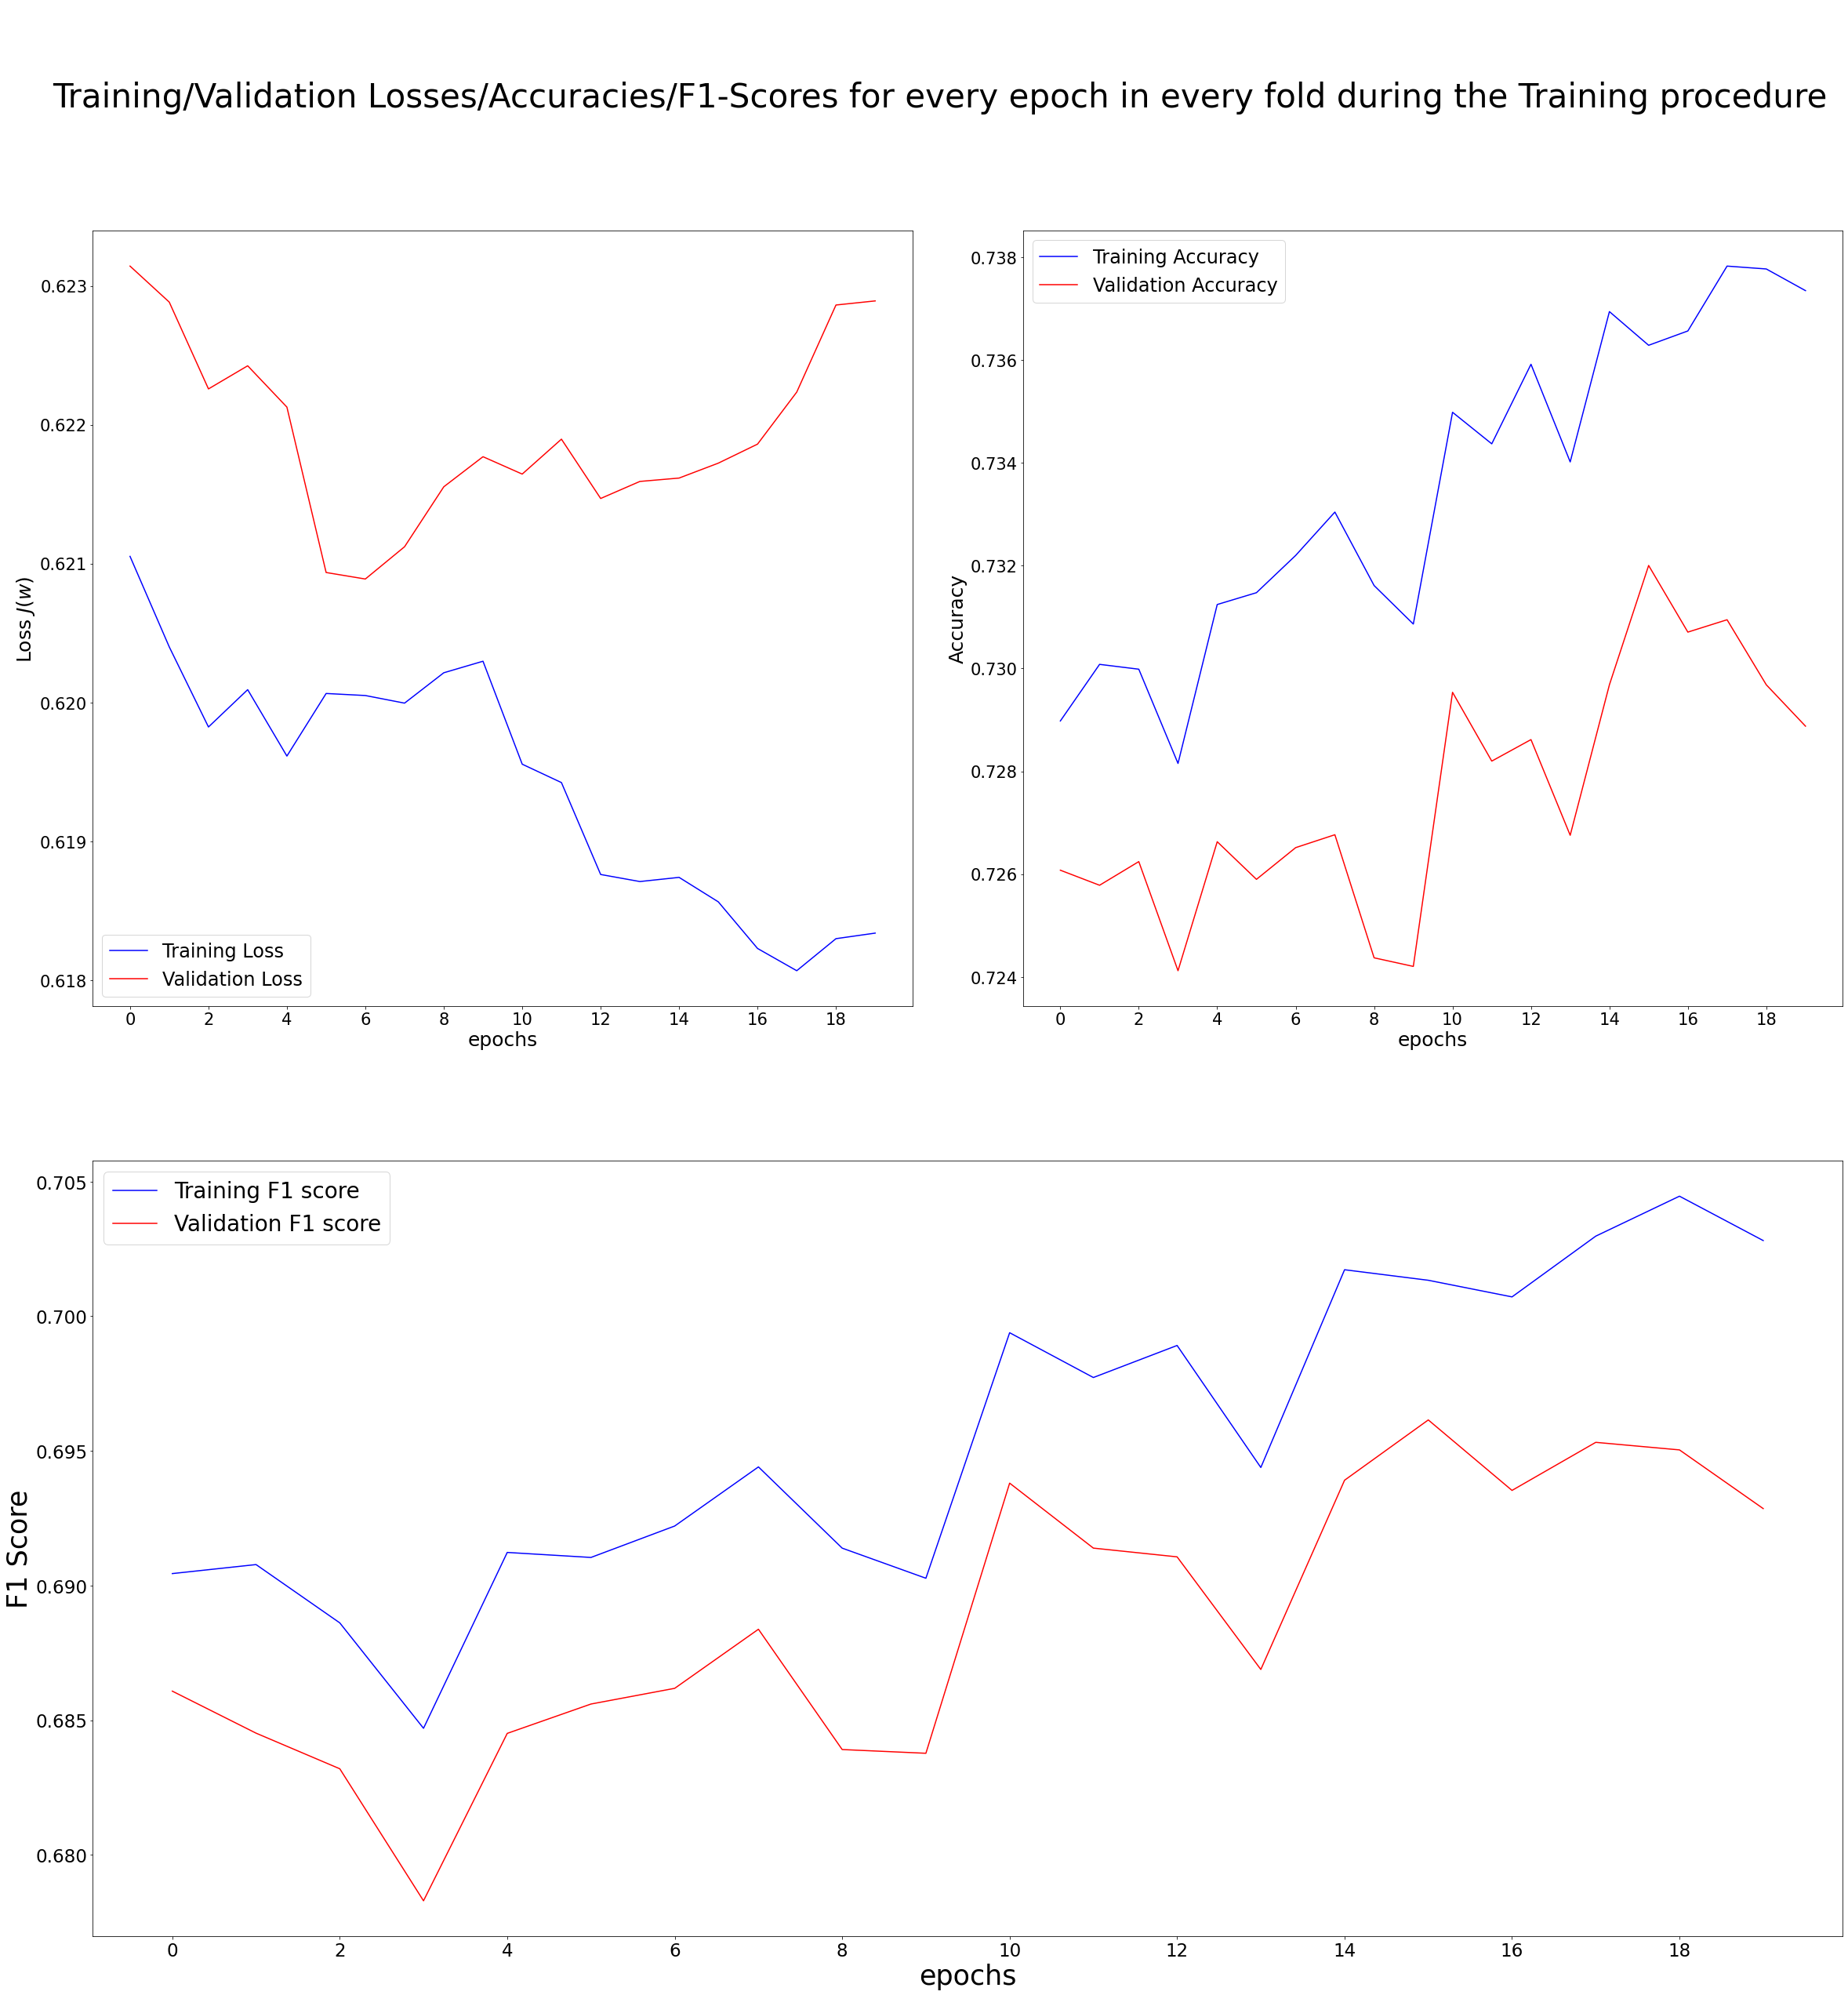

In [50]:
# function can be found in train.py
histories1 = k_fold_train(model1, X_train1, y_train1, crossentropy_loss1,
                          optimizer1, hyperparameters1, k=4,
                          early_stopping=False, restore_best_weights=True,
                          target_metric="val_f1", target_file="./model1.pth",
                          plot_curves=True, verbose=True)

In [51]:
# make the prediction on the test set
y_pred1 = model1(X_test1, test=True)
# accuracy for test set, function can be found in metrics.py
acc_1 = accuracy(y_pred1, y_test1)
# f1 score for test set, function can be found in metrics.py
f1_1 = f1_score(y_pred1, y_test1)

# print the information
print("Model 1 performance on the Test Set")
print("Accuracy: {}, F1-Score: {}".format(acc_1, f1_1))

Model 1 performance on the Test Set
Accuracy: 0.7342974720752499, F1-Score: 0.7612668765450359



Fold: 1
	epoch: 1
		Training Loss: 0.64, Validation Loss: 0.64, Training Accuracy: 0.69, Validation Accuracy: 0.69
		Training F1-score: 0.62, Validation F1-score: 0.62
	epoch: 2
		Training Loss: 0.64, Validation Loss: 0.64, Training Accuracy: 0.69, Validation Accuracy: 0.69
		Training F1-score: 0.63, Validation F1-score: 0.62
	epoch: 3
		Training Loss: 0.64, Validation Loss: 0.64, Training Accuracy: 0.69, Validation Accuracy: 0.69
		Training F1-score: 0.63, Validation F1-score: 0.63
	epoch: 4
		Training Loss: 0.64, Validation Loss: 0.64, Training Accuracy: 0.69, Validation Accuracy: 0.69
		Training F1-score: 0.63, Validation F1-score: 0.62
	epoch: 5
		Training Loss: 0.64, Validation Loss: 0.64, Training Accuracy: 0.69, Validation Accuracy: 0.69
		Training F1-score: 0.63, Validation F1-score: 0.63

Fold: 2
	epoch: 1
		Training Loss: 0.64, Validation Loss: 0.64, Training Accuracy: 0.69, Validation Accuracy: 0.69
		Training F1-score: 0.63, Validation F1-score: 0.63
	epoch: 2
		Training L

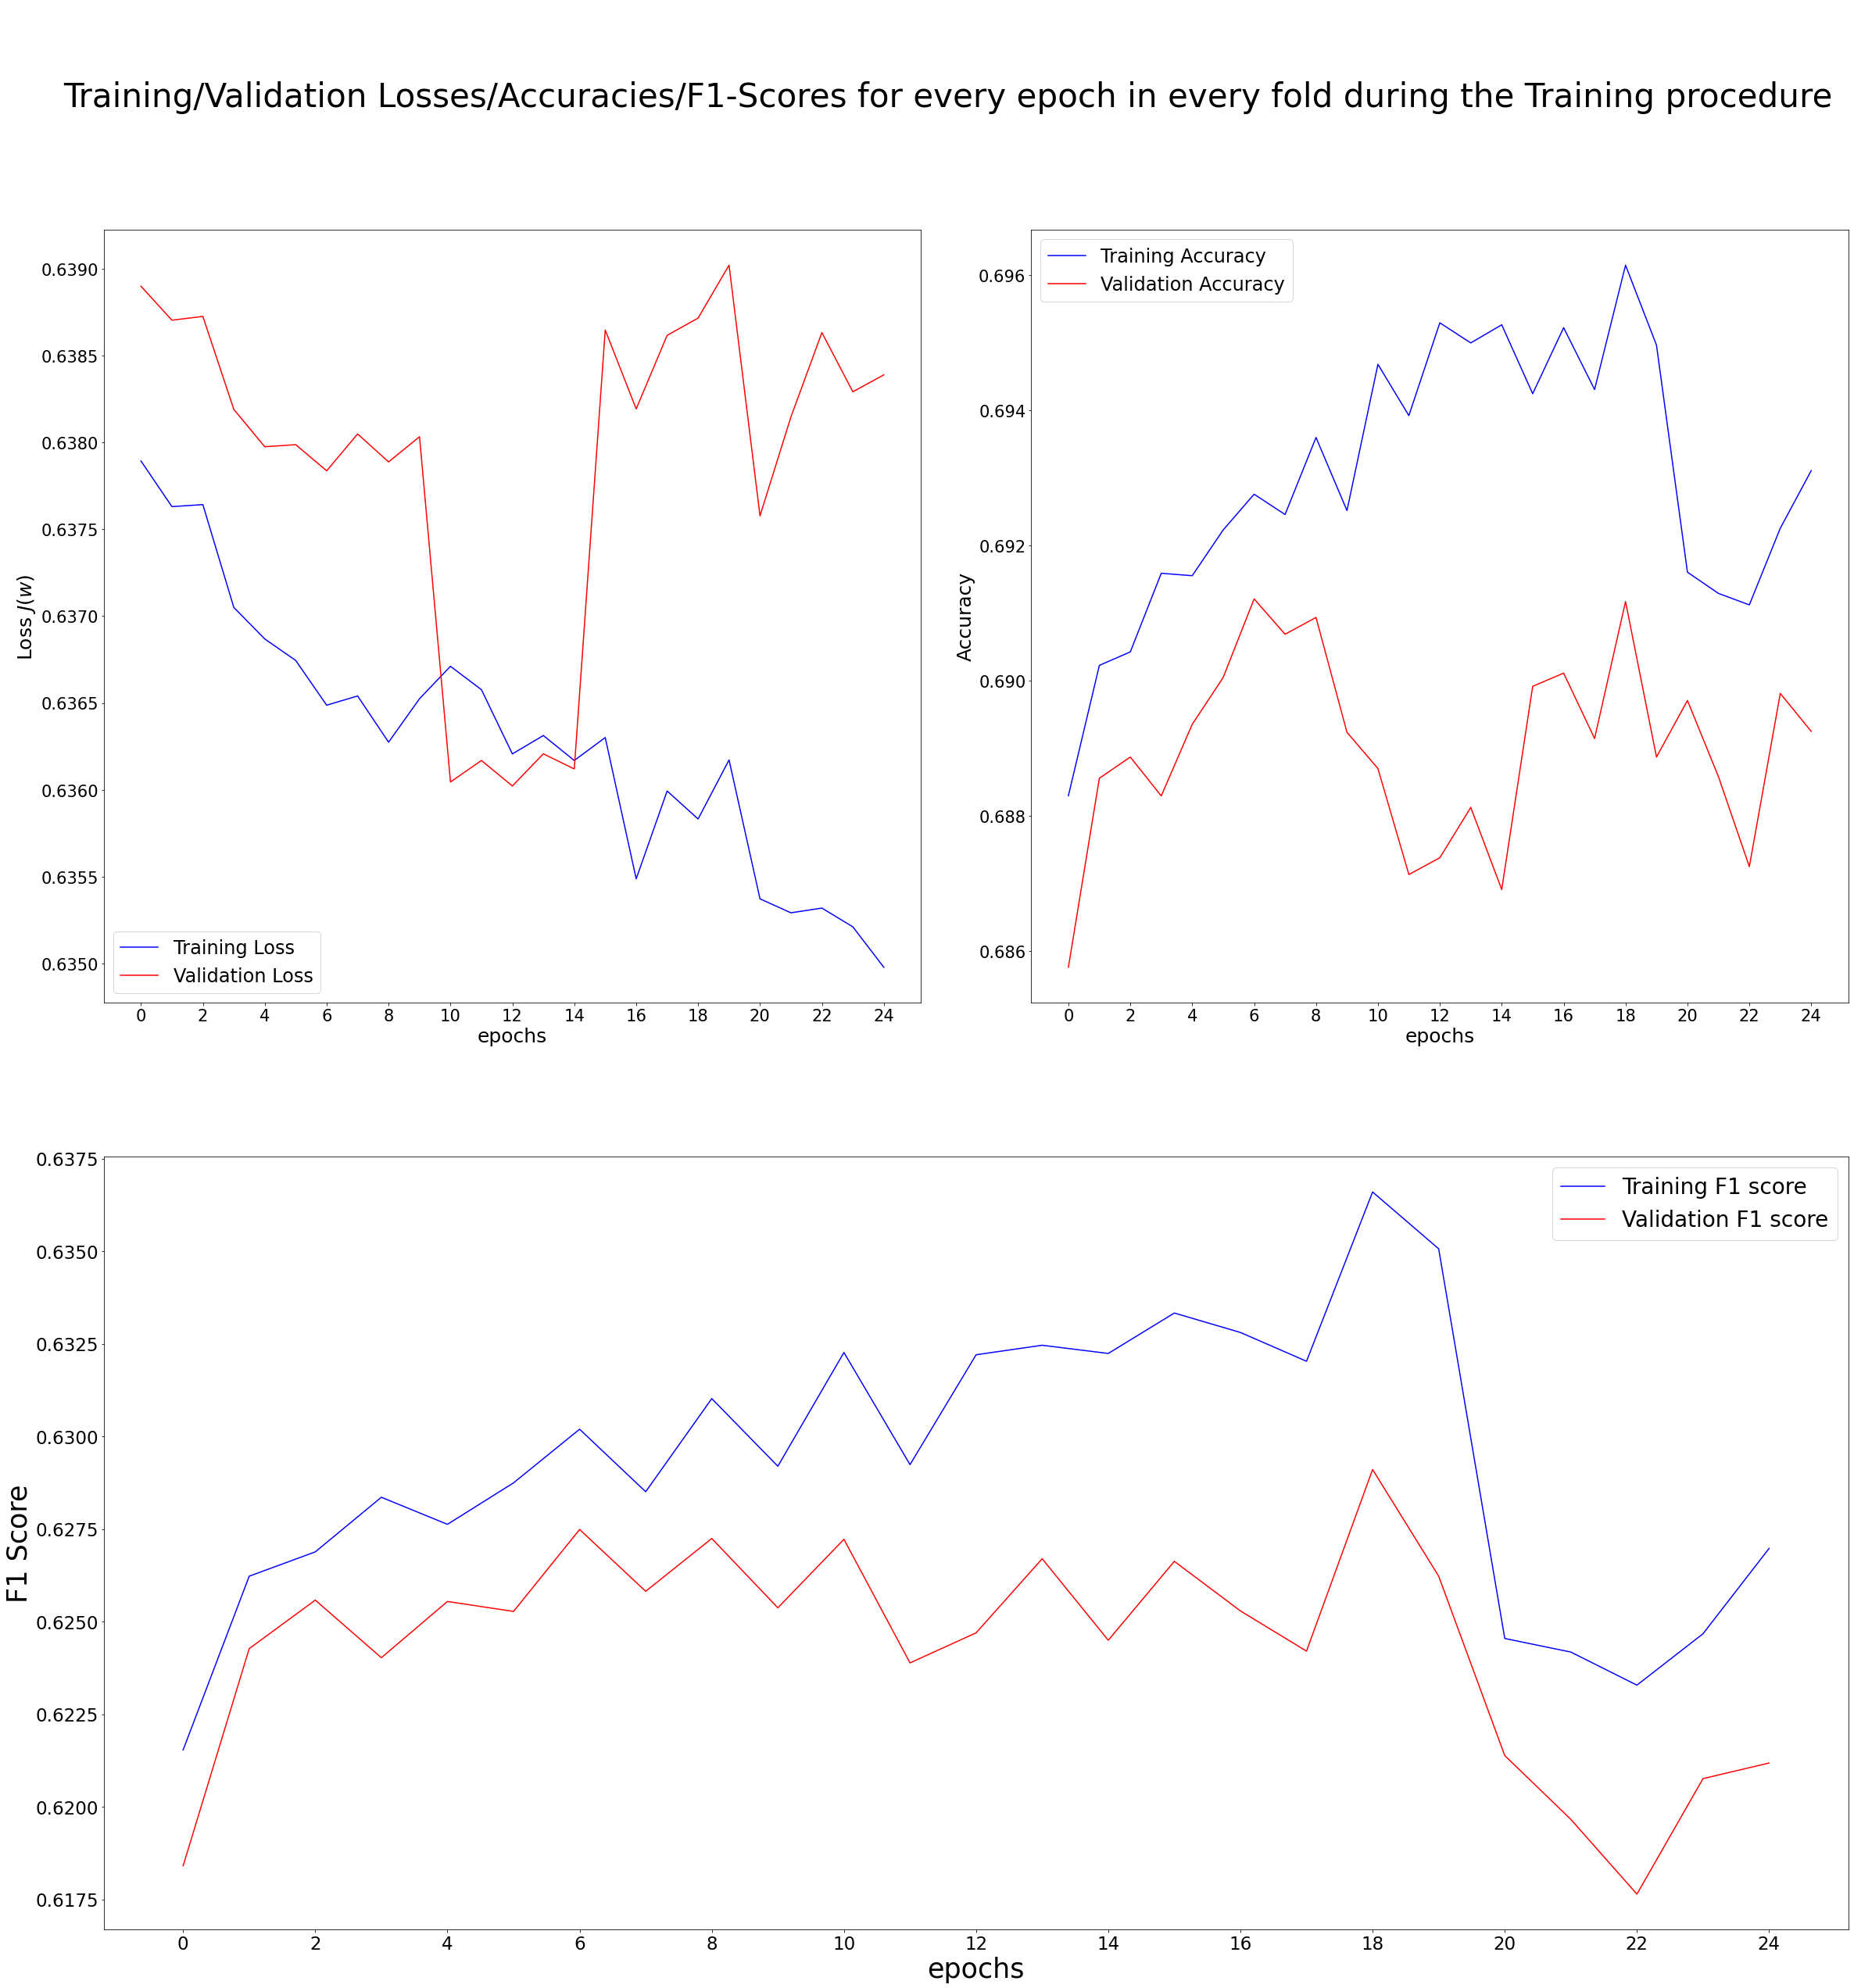

In [52]:
# function can be found in train.py
histories2 = k_fold_train(model2, X_train2, y_train2, crossentropy_loss2,
                          optimizer2, hyperparameters2, k=5,
                          early_stopping=False, restore_best_weights=True,
                          target_metric="val_f1", target_file="./model2.pth",
                          plot_curves=True, verbose=True)

In [53]:
# make the prediction on the test set
y_pred2 = model2(X_test2, test=True)
# accuracy for test set, function can be found in metrics.py
acc_2 = accuracy(y_pred2, y_test2)
# f1 score for test set, function can be found in metrics.py
f1_2 = f1_score(y_pred2, y_test2)

# print the information
print("Model 2 performance on the Test Set")
print("Accuracy: {}, F1-Score: {}".format(acc_2, f1_2))


Model 2 performance on the Test Set
Accuracy: 0.6562492651381541, F1-Score: 0.53246337875008


## Define a Custom Grid Search

In [54]:
def custom_grid_search(name, learning_rates, weight_decays, X, y, target_file):
  """ Custom Grid Search for learning rate and weight decay, but can be easily
      changed to tune more hyperparameters """

  # get the sets
  X_train, X_test = X
  y_train, y_test = y

  # define the best configuration
  best_config = None
  best_f1 = 0

  # start grid search here
  for lr in learning_rates:
    for wd in weight_decays:

      # create the model here
      if name == "1":
        print("Creating model1 for lr: {} and wd: {}".format(lr, wd))
        model = Network1(input_shape=X_train.shape[1])
      else:
        print("Creating model2 for lr: {} and wd: {}".format(lr, wd))
        model = Network2(input_shape=X_train.shape[1])

      # define the hyperparameters for the model
      learning_rate = lr
      weight_decay = wd
      batch_size = 32
      epochs = 5

      # define a dictionary to avoid carrying all of them around
      hyperparameters = {
          "learning_rate": learning_rate,
          "weight_decay": weight_decay,
          "batch_size": batch_size,
          "epochs": epochs
      }

      # define here the loss and the optimizer (Adam is quite slow)
      crossentropy_loss = nn.BCEWithLogitsLoss()
      if name == "1":
        optimizer = torch.optim.RMSprop(model.parameters(),
                                        lr=hyperparameters["learning_rate"],
                                        weight_decay=hyperparameters["weight_decay"])
      else:
        optimizer = torch.optim.Adam(model.parameters(),
                                     lr=hyperparameters["learning_rate"],
                                     weight_decay=hyperparameters["weight_decay"])
      
      # kfold train the model
      histories = k_fold_train(model, X_train, y_train, crossentropy_loss,
                               optimizer, hyperparameters, k=5,
                               early_stopping=False, restore_best_weights=True,
                               target_metric="val_f1", target_file="./model1.pth",
                               plot_curves=False, verbose=False)
      
      # make the prediction on the test set
      y_pred = model(X_test, test=True)
      # accuracy for test set, function can be found in metrics.py
      acc = accuracy(y_pred, y_test)
      # f1 score for test set, function can be found in metrics.py
      f1 = f1_score(y_pred, y_test)

      # print the information
      print("\nModel {} performance on the Test Set for Learning Rate {} and Weight Decay {}:".format(name, lr, wd))
      print("Accuracy: {}, F1-Score: {}\n\n".format(acc, f1))

      # check if this is a better configuration
      if f1 > best_f1:
        best_config = (lr, wd)
        best_f1 = f1

  # return the best results
  return best_config, best_f1

### Run here with smaller a Dataset (1/20 of the original) the Grid Search for every kind of model ("1" or "2")

In [55]:
"""
# custom grid search for model1
model1_lr = [0.0005, 0.0001, 0.00001, 0.000001]
model1_wd = [0.001, 0.0001, 0.00001]
inputs1 = (X_train1, X_test1)
outputs1 = (y_train1, y_test1)
best_config1, best_f1_1 = custom_grid_search("1", model1_lr, model1_wd, inputs1, outputs1, "model1.pth")
print("\n\nFor Learning Rate: {} and Weight Decay: {}, the best F1 score for "
      "model 1 was achieved: {}".format(best_config1[0], best_config1[1], best_f1_1))
"""

'\n# custom grid search for model1\nmodel1_lr = [0.0005, 0.0001, 0.00001, 0.000001]\nmodel1_wd = [0.001, 0.0001, 0.00001]\ninputs1 = (X_train1, X_test1)\noutputs1 = (y_train1, y_test1)\nbest_config1, best_f1_1 = custom_grid_search("1", model1_lr, model1_wd, inputs1, outputs1, "model1.pth")\nprint("\n\nFor Learning Rate: {} and Weight Decay: {}, the best F1 score for "\n      "model 1 was achieved: {}".format(best_config1[0], best_config1[1], best_f1_1))\n'

In [56]:
"""
# custom grid search for model2
model2_lr = [0.0005, 0.0001, 0.00001]
model2_wd = [0.001, 0.0001, 0.00001]
inputs2 = (X_train2, X_test2)
outputs2 = (y_train2, y_test2)
best_config2, best_f1_2 = custom_grid_search("2", model2_lr, model2_wd, inputs2, outputs2, "model2.pth")
print("\n\nFor Learning Rate: {} and Weight Decay: {}, the best F1 score for "
      "model 2 was achieved: {}".format(best_config2[0], best_config2[1], best_f1_2))
"""

'\n# custom grid search for model2\nmodel2_lr = [0.0005, 0.0001, 0.00001]\nmodel2_wd = [0.001, 0.0001, 0.00001]\ninputs2 = (X_train2, X_test2)\noutputs2 = (y_train2, y_test2)\nbest_config2, best_f1_2 = custom_grid_search("2", model2_lr, model2_wd, inputs2, outputs2, "model2.pth")\nprint("\n\nFor Learning Rate: {} and Weight Decay: {}, the best F1 score for "\n      "model 2 was achieved: {}".format(best_config2[0], best_config2[1], best_f1_2))\n'

## Plot the ROC curves on the test sets to get a better picture of the perfomance of the models

In [57]:
# define here the variables passed in the plot_roc_curves() function
models = [model1, model2]
modelnames = {model1: "NN with tfidf", model2: "NN with GloVe"}
colors = {model1: "royalblue", model2: "maroon"}
Test_Sets_X = {model1: X_test1, model2: X_test2}
Test_Sets_y = {model1: y_test1, model2: y_test2}

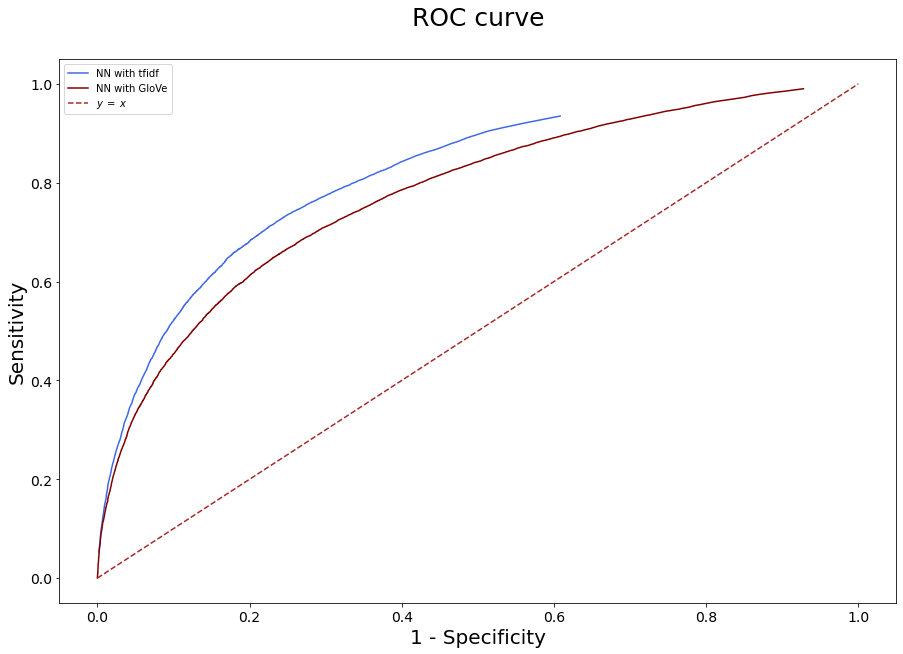

In [58]:
# function can be found in plots.py
plot_roc_curves(models, modelnames, colors, Test_Sets_X, Test_Sets_y)

## Let's make a prediction with model1

In [59]:
# enter here your sentence, run it through the pipeline and get a result
custom_sentence = ["This assignment was fun and I really enjoyed it"]
X1 = network1_pipeline(custom_sentence, tfidf)
y1 = model1(X1, test=True)
sentiment = "positive" if y1.item() >= 0.5 else "negative"
print("Model 1 predicts that the sentence: \n\n\"{}\"\n\n has a {} sentiment".format(custom_sentence[0], sentiment))

Model 1 predicts that the sentence: 

"This assignment was fun and I really enjoyed it"

 has a positive sentiment


## Let's make a prediction with model2

In [60]:
# enter here your sentence, run it through the pipeline and get a result
custom_sentence = ["This assignment took a lot of my time and now I can't catch up with other assignments"]
X2 = network2_pipeline(custom_sentence, index_to_vector, word_to_index_glove,
                       maxlen, embedding_dimension, pad_token, unknown_token)
y2 = model2(X2, test=True)
sentiment = "positive" if y2.item() >= 0.5 else "negative"
print("Model 2 predicts that the sentence: \n\n\"{}\"\n\n has a {} sentiment".format(custom_sentence[0], sentiment))

Model 2 predicts that the sentence: 

"This assignment took a lot of my time and now I can't catch up with other assignments"

 has a negative sentiment
